In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
#Import CDO and make sure it works
from cdo import *

#--Initialize CDO
cdo=Cdo()

%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import matplotlib.colors as colors
import collections

os.chdir('/vftmp/Jane.Baldwin/HW_REVIEW/')

In [5]:
#Analysis for Maps
defxn = 'n'
defday = '3114'
pctn = '90'

files = {'Control':'t'+defxn+pctn+'pct_heatwaves_FLOR_Control_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        'XYTave':'t'+defxn+pctn+'pct_heatwaves_FLOR_XYTave_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        '2xCO2':'t'+defxn+pctn+'pct_heatwaves_FLOR_2XCO2_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        'Tave':'t'+defxn+pctn+'pct_heatwaves_FLOR_Tave_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        '365':'t'+defxn+pctn+'pct_heatwaves_FLOR_365_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc'}

head = files['Control'][0:7]

ahwf0 = {}
ahwf = {}
ahw2f = {}
cp = {}
cp_diff = {}
ahwfp = {}

for key, value in files.iteritems():
    ahwf0[key] = cdo.timmean(input = '-selvar,%s %s' %('AHWF_'+head,value),output = key+'_ahwf_'+defday+defxn+pctn+'.nc',
                           options='-f nc', returnCdf=True)
    ahwf[key] = np.squeeze(ahwf0[key]['AHWF_'+head][:])
    ahw2f[key] = cdo.timmean(input = '-selvar,%s %s' %('AHW2F_'+head,value),output = key+'_ahw2f_'+defday+defxn+pctn+'.nc',
                           options='-f nc', returnCdf=True)
    ahw2f[key] = np.squeeze(ahw2f[key]['AHW2F_'+head][:])
    cp[key] = cdo.mulc(100,input = '-div %s %s' %(key+'_ahw2f_'+defday+defxn+pctn+'.nc',key+'_ahwf_'+defday+defxn+pctn+'.nc'), 
                       output = key+'_cp_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True) 
    cp[key] = np.squeeze(cp[key]['AHW2F_'+head][:])
    ahwfp[key] = ahwf[key]/153*100

for key in ['2xCO2','XYTave', 'Tave', '365']:
    cp_diff[key] = cdo.sub(input = '%s %s' %(key+'_cp_'+defday+defxn+pctn+'.nc','Control_cp_'+defday+defxn+pctn+'.nc'), 
                           output = key+'_cp_diff_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True)
    cp_diff[key] = np.squeeze(cp_diff[key]['AHW2F_'+head][:])
    
lats0 = ahwf0['2xCO2']['lat'][:]
lons0 = ahwf0['2xCO2']['lon'][:]

In [6]:
#Calculates means

lat_s = -90
lat_n = 90
lon_w = 0
lon_e = 360

mlats = np.transpose(np.tile(lats0,(lons0.shape[0],1)))
weights = np.cos(np.deg2rad(mlats))
mlons = np.tile(lons0,(lats0.shape[0],1))
lats_mask = np.logical_and(mlats >= lat_s, mlats <= lat_n)
lons_mask = np.logical_and(mlons >= lon_w, mlons <= lon_e)
reg_mask = lats_mask*lons_mask

def spacemean(var):
    regmean = np.ma.average(var[reg_mask], weights = weights[reg_mask])
    return regmean

lat_0 = lats0.mean()
lon_0 =  lons0.mean()

parallels = np.arange(-90.,90,30.)
meridians = np.arange(0.,360.,60.)

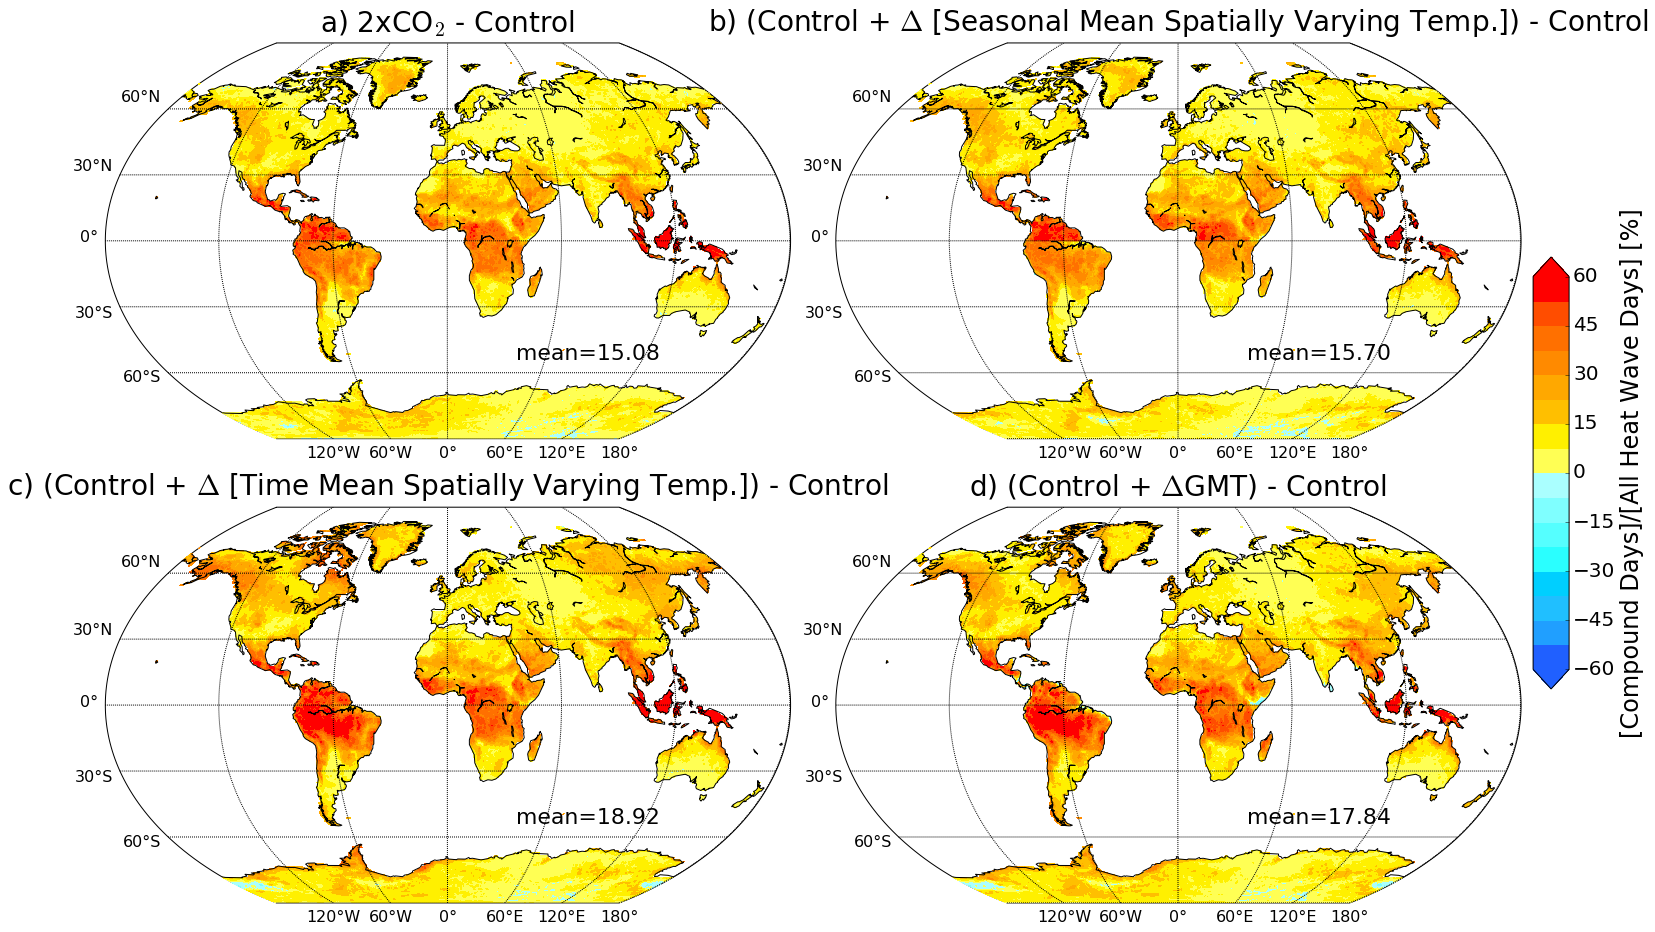

In [16]:
#Difference Maps
fig = plt.figure(figsize=(20,12))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 180
x1 = start+sf
lon0 = start+180+sf

ax1 = plt.subplot(2,2,1)
var = cp_diff['2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax2 = plt.subplot(2,2,2)
var = cp_diff['365']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax3 = plt.subplot(2,2,3)
var = cp_diff['Tave']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax4 = plt.subplot(2,2,4)
var = cp_diff['XYTave']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax4.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax4.transAxes,fontsize=22)

ax1.text(0.5,1.05, "a) 2xCO$_{2}$ - Control", transform=ax1.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')
ax1.text(0.5,1.05, "b) (Control + $\Delta$ [Seasonal Mean Spatially Varying Temp.]) - Control", transform=ax2.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')
ax1.text(0.5,1.05, "c) (Control + $\Delta$ [Time Mean Spatially Varying Temp.]) - Control", transform=ax3.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')
ax4.text(0.5,1.05, "d) (Control + $\Delta$GMT) - Control", transform=ax4.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')


cax = fig.add_axes([1, 0.25, 0.025, 0.5])
art = plt.colorbar(cs, cax, orientation='vertical')
art.set_label('[Compound Days]/[All Heat Wave Days] [%]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=2.5, h_pad=8)

fig.savefig('meanshifts.pdf', bbox_inches='tight')